In [1]:
import pandas as pd 
import uproot as ur
import numpy as np
import awkward as ak
from sklearn.utils import shuffle

/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
file = ur.open("fwdtree_Bz.root")
tree = file["fwd"]
branch_names = ["fstHits.mXYZ.fX", "fstHits.mXYZ.fY", "fstHits.mXYZ.fZ","mcTracks.mPxyz.mX1","mcTracks.mPxyz.mX2","mcTracks.mPxyz.mX3","mcTracks.mId","fstHits.mIdTruth",
                "mcTracks.mPxyz.mX1","mcTracks.mPxyz.mX2","mcTracks.mPxyz.mX3","mcTracks.mId"]

In [3]:
def read_tracks_and_momentum_from_branch(branch, valid_lengths=3):
    track_list = []
    momentum_list = []
    used_branch_id = []
    branch_ids = branch["fstHits.mIdTruth"]
    
    for branch_id in branch_ids:
        if branch_id not in used_branch_id:
            index_track = ak.where(branch_id == branch["fstHits.mIdTruth"])[0]  # Ensure the indices are flattened
            pos_x, pos_y, pos_z = [], [], []

            for index in index_track:
                pos_x.append(branch["fstHits.mXYZ.fX"][index])
                pos_y.append(branch["fstHits.mXYZ.fY"][index])
                pos_z.append(branch["fstHits.mXYZ.fZ"][index])
            combined = list(zip(pos_x, pos_y, pos_z))
            
            if len(combined) == valid_lengths:
                track_list.append(combined)
                # If the track is valid, include its corresponding momentum
                px = branch["mcTracks.mPxyz.mX1"][branch_id-1]
                py = branch["mcTracks.mPxyz.mX2"][branch_id-1]
                pz = branch["mcTracks.mPxyz.mX3"][branch_id-1]
                momentum_list.append([px, py, pz])
            
            used_branch_id.append(branch_id)
    
    return track_list, momentum_list

def read_tracks_and_momentum_from_branches(branches, valid_lengths=3):
    all_tracks = []
    all_momentum = []
    
    for branch in branches:
        branch_tracks, branch_momentum = read_tracks_and_momentum_from_branch(branch, valid_lengths)
        all_tracks.extend(branch_tracks)
        all_momentum.extend(branch_momentum)
    
    return all_tracks, all_momentum

def pad_track_list_by_nan(track_list):
    padded_tracks = []
    for hits in track_list:
        padding_num = 3 - len(hits)
        padded_hits = hits + [(np.nan, np.nan, np.nan)] * padding_num
        padded_tracks.append(padded_hits)
    return padded_tracks

def sort_subarrays_by_z_and_nan(arr):
    sorted_arr = []
    for subarray in arr:
        nan_mask = np.isnan(subarray).all(axis=1)
        non_nan_entries = subarray[~nan_mask]
        nan_entries = subarray[nan_mask]
        sorted_non_nan_entries = non_nan_entries[non_nan_entries[:, 2].argsort()]
        sorted_subarray = np.vstack((sorted_non_nan_entries, nan_entries))
        sorted_arr.append(sorted_subarray)
    return np.array(sorted_arr)


def sort_subarrays_by_z(arr):
    sorted_arr = []
    for subarray in arr:
        non_nan_entries = subarray[~np.isnan(subarray).any(axis=1)]
        
        sorted_non_nan_entries = non_nan_entries[non_nan_entries[:, 2].argsort()]
        sorted_arr.append(sorted_non_nan_entries)
    
    return np.array(sorted_arr)



def linear_fit(row, col1, col2, col3):
    if pd.isna(row[col3]):
        return 2 * row[col2] - row[col1]
    return row[col3]

def linear_fit_implace(training_features):
    training_features['L3X'] = training_features.apply(lambda row: linear_fit(row, 'L1X','L2X','L3X'),axis=1)
    training_features['L3Y'] = training_features.apply(lambda row: linear_fit(row, 'L1Y','L2Y','L3Y'),axis=1)
    training_features['L3Z'] = training_features.apply(lambda row: linear_fit(row, 'L1Z','L2Z','L3Z'),axis=1)
    return training_features
    

In [4]:
branches = tree.arrays(branch_names)

In [5]:
track_list,momentum_list = read_tracks_and_momentum_from_branches(branches)

In [6]:
track_list = sort_subarrays_by_z(np.array(track_list))
track_list = np.array([subarr.flatten() for subarr in track_list])

In [7]:
momentum_list = np.array(momentum_list)

In [8]:
feature_frame = pd.DataFrame({ 'L1X':track_list[:,0],'L1Y':track_list[:,1],'L1Z':track_list[:,2]
                               ,'L2X':track_list[:,3],'L2Y':track_list[:,4],'L2Z':track_list[:,5]
                               ,'L3X':track_list[:,6],'L3Y':track_list[:,7],'L3Z':track_list[:,8]
                               })

output_frame = pd.DataFrame({'px':momentum_list[:,0],'py':momentum_list[:,1],'pz':momentum_list[:,2]})



In [9]:
px = output_frame['px'].values
py = output_frame['py'].values
pz = output_frame['pz'].values

# Compute pt, eta, phi
pt = np.sqrt(px**2 + py**2)
phi = np.arctan2(py, px)
eta = np.arcsinh(pz / pt)  

# Create a new DataFrame for the transformed target variables
output_frame = pd.DataFrame({'pt': pt, 'eta': eta, 'phi': phi})

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures


X = feature_frame.values
y = output_frame.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

initial_learning_rate = 0.000001
initial_iter = 1000
n_total_epochs = 100000

mlp = MLPRegressor(hidden_layer_sizes=(32,16,8), max_iter=initial_iter, random_state=42, solver="adam", activation="relu",warm_start=True,batch_size="auto",learning_rate="constant",learning_rate_init=initial_learning_rate, alpha=0.3)

mse_pt = []
mse_eta = []
mse_phi = []

mae_pt = []
mae_eta = []
mae_phi = []

for epoch in range(n_total_epochs):
    mlp.fit(X_train_scaled,y_train_scaled)
    y_pred_scaled = mlp.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mse_pt.append(mean_squared_error(y_test[:,0],y_pred[:,0]))
    mse_eta.append(mean_squared_error(y_test[:,1],y_pred[:,1]))
    mse_phi.append(mean_squared_error(y_test[:,2],y_pred[:,2]))
    mae_pt.append(mean_absolute_error(y_test[:,0],y_pred[:,0]))
    mae_eta.append(mean_absolute_error(y_test[:,1],y_pred[:,1]))
    mae_phi.append(mean_absolute_error(y_test[:,2],y_pred[:,2]))



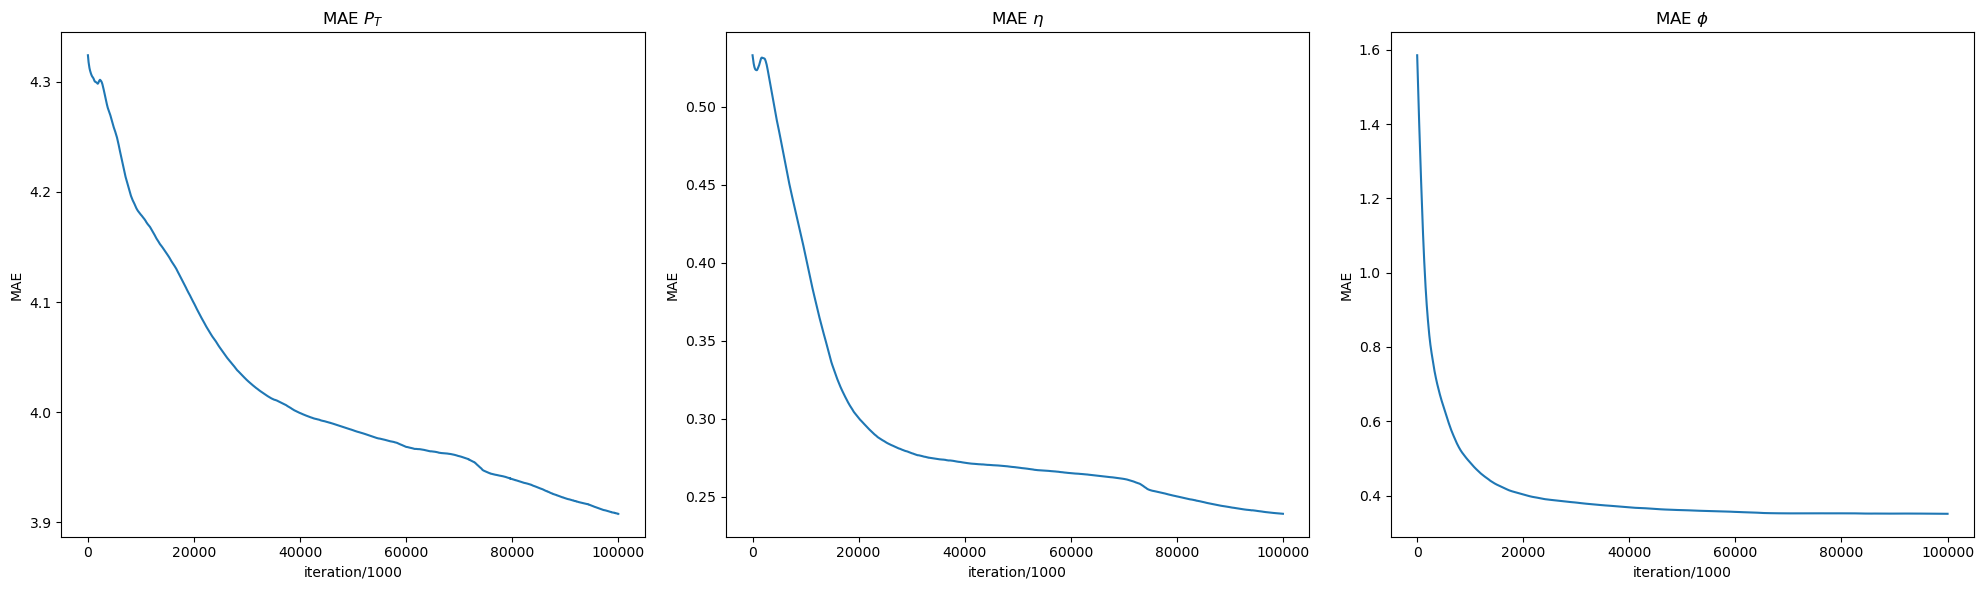

3.9078153412315184 0.23911641248448254 0.3510666716170812


In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize = (20,6))

axs[0].plot(mae_pt)
axs[0].set_title("MAE $P_T$")
axs[1].plot(mae_eta)
axs[1].set_title("MAE $\eta$")
axs[2].plot(mae_phi)
axs[2].set_title("MAE $\phi$")

for ax in axs:
    ax.set_xlabel("iteration/1000")
    ax.set_ylabel("MAE")

plt.tight_layout()
plt.show()

print(min(mae_pt), min(mae_eta), min(mae_phi))


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scorer, n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train_scaled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters found: ", best_params)
print("Best CV Score (MAE): ", -best_score)

best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = best_rf.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse_pt_rf = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_eta_rf = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mse_phi_rf = mean_squared_error(y_test[:, 2], y_pred[:, 2])

mae_pt_rf = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_eta_rf = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_phi_rf = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

print("MAE - pt: ", mae_pt_rf)
print("MAE - eta: ", mae_eta_rf)
print("MAE - phi: ", mae_phi_rf)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=700; total time=   4.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END max_depth=None

/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
459 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/xihehan/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_pa

Best Parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700}
Best CV Score (MAE):  0.41416106018388765
MAE - pt:  4.10047927598269
MAE - eta:  0.20974156160293211
MAE - phi:  0.2494453137651039
